# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Read files

In [4]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()

X_val = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
X_val = X_val.reset_index(drop=True)
y_val = X_val.ctx0.copy()

X_test = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
X_test = X_test.reset_index(drop=True)
y_test = X_test.ctx0.copy()


CPU times: user 40.4 s, sys: 2.89 s, total: 43.3 s
Wall time: 43.3 s


In [5]:
cat_y_train = ((y_train.copy()*100)/5).round().astype(int)
cat_y_val = ((y_val.copy()*100)/5).round().astype(int)
cat_y_test = ((y_test.copy()*100)/5).round().astype(int)

# View

In [6]:
years = X_train.year.unique().tolist()
years

[2019, 2020, 2021, 2022]

In [7]:
months = X_train.month.unique().tolist()
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Run pipeline

In [8]:
X_train.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'timestamp',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
       'lon', 'lat', 'festius', 'festius_sun', 'festius_sun_sat', 'weekend',
       'VALOR_TN_X4', 'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4',
       'ctx1_ctx2_mean', 'ctx1_ctx2_std', 'ctx1_ctx2_ctx3_mean',
       'ctx1_ctx2_ctx3_std', 'ctx1_ctx2_ctx3_ctx4_mean',
       'ctx1_ctx2_ctx3_ctx4_std'],
      dtype='object')

In [9]:
%%time 

columns = X_train.columns[['VALOR' not in i for i in X_train.columns]].to_list()

correlations = np.abs(
    X_train[columns].corr(method='pearson').ctx0
).sort_values(ascending=False)

correlations.to_dict()

CPU times: user 21.2 s, sys: 612 ms, total: 21.8 s
Wall time: 21.8 s


{'ctx0': 1.0,
 'ctx1': 0.9129730514796786,
 'num_docks_available': 0.9055683555185408,
 'num_bikes_available': 0.8893401764262853,
 'ctx1_ctx2_mean': 0.8749838959980545,
 'num_bikes_available_types.mechanical': 0.8419660611344777,
 'ctx1_ctx2_ctx3_mean': 0.8385814221879833,
 'ctx1_ctx2_ctx3_ctx4_mean': 0.8038040173697454,
 'ctx2': 0.798489435958584,
 'ctx3': 0.6970754741833134,
 'ctx4': 0.6062960341913912,
 'lon': 0.263030547218921,
 'num_bikes_available_types.ebike': 0.2176339648798674,
 'ctx1_ctx2_ctx3_ctx4_std': 0.12158394131660635,
 'ctx1_ctx2_ctx3_std': 0.10959527196946488,
 'ctx1_ctx2_std': 0.0907243095776992,
 'lat': 0.07074776190628096,
 'station_id': 0.06967142131249375,
 'timestamp': 0.061366489615208346,
 'year': 0.051252756351171845,
 'dayofyear': 0.04284937914584141,
 'month': 0.042743878873176405,
 'hour': 0.02565808047205957,
 'weekend': 0.019847936776268647,
 'dayofweek': 0.016400115218987096,
 'festius_sun_sat': 0.015699847602472793,
 'festius_sun': 0.01451383074908687

In [10]:
columns_ctx = X_train.columns[['ctx' in i for i in X_train.columns]].to_list()
columns_ctx.remove('ctx0')
print(len(columns_ctx))

columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4']
print(len(columns_meteo))

columns_time = ['month', 'dayofyear', 'hour'] # dayofweek, day 
print(len(columns_time))

columns_location = ['lon', 'lat']
print(len(columns_location))

columns_festius = ['festius_sun', 'weekend']
print(len(columns_festius))


10
4
3
2
2


In [11]:
class Config:
    num_attribs0 = ['capacity'] + columns_ctx + columns_meteo
    cat_attribs0 = columns_time
    cat_attribs1 = ['']
    gen_attribs0 = ['station_id'] + columns_festius + columns_location
    target_col = ['ctx0']
    
    seed=42
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [12]:
config=Config()
seed_everything(config.seed)

In [13]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
#             ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [14]:
%%time 

full_pipeline = build_preprocessor(config)

CPU times: user 34 µs, sys: 3 µs, total: 37 µs
Wall time: 39.3 µs


In [15]:
full_pipeline.fit(X_train)

ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
                                  'ctx1_ctx2_mean', 'ctx1_ctx2_std',
                                  'ctx1_ctx2_ctx3_mean', 'ctx1_ctx2_ctx3_std',
                                  'ctx1_ctx2_ctx3_ctx4_mean',
                                  'ctx1_ctx2_ctx3_ctx4_std', 'VALOR_TN_X4',
                                  'VALOR_TM_X4', 'VALOR_TX_X4',
                                  'VALOR_PPT_X4']),
                                ('gen1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['station_id', 'festius_sun', 'weekend', 'lon',
                                  'lat']),
                                ('cat0',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['month', 'dayofyear', 'hour'])])

In [16]:
def apply_pipeline(pipline, X, y, args=None, show=True):
    assert X.shape[0] == y.shape[0]
    
    X_prepared = full_pipeline.transform(X)
    
    if show:
        print("X", X.shape, 
              "X_prepared:", X_prepared.shape,
              "y: ", y.shape
             )
        
    if args:
        return X_prepared, y, *args
    else:
        return X_prepared, y

def prepare_splits(
    pipeline,
    data_train,
    data_val,
    data_test,
    years, 
    months, 
    show=True
):
    if show:
        print("train")
    
    train_cond = (data_train[0].year.isin(years) & data_train[0].month.isin(months))
    Xtr, ytr = apply_pipeline(
        pipeline,
        data_train[0][train_cond], 
        data_train[1][train_cond],
        show=show
    )

    if show:
        print("val")
    
    val_cond = (data_val[0].year.isin(years) & data_val[0].month.isin(months))
    Xva, yva = apply_pipeline(
        pipeline, 
        data_val[0][val_cond], 
        data_val[1][val_cond],
        show=show
    )

    if show:
        print("test")
    
    test_cond = (data_test[0].year.isin([2023]) & data_test[0].month.isin([3]))
    Xte, yte = apply_pipeline(
        pipeline, 
        data_test[0][test_cond],
        data_test[1][test_cond],
        show=show
    )
    
    return Xtr, ytr, Xva, yva, Xte, yte

def test_model_train_val_test(
    model,
    data_train,
    data_val,
    data_test,
    skip_cv=False,
    show=False,
    error_score='raise'
):
    if skip_cv==False:
        cross_val_evaluation(
            model, 
            data_train[0], 
            data_train[1], 
            'model test', 
            n_jobs=5,
            error_score=error_score
        )
    
    model.fit(data_train[0], data_train[1])
    
    return {
        'train':test_model(model, data_train[0], data_train[1], show=show)[['mse_t','rmse_t','mae_t','r2_t']],
        'test':test_model(model, data_val[0], data_val[1], data_test[0], data_test[1], show=show)[['mse_t','rmse_t','mae_t','r2_t', 'mse_v','rmse_v','mae_v','r2_v']]
    }


def do_test_per_month(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], [month], False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
                
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

def do_test_per_month_combos(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month_combo = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month_combo}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], month_combo, False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
            
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

def print_grid_result(result, parm):    
    #plot the results
    plt.figure(figsize=(8, 8))
    plt.title("GridSearchCV",
              fontsize=16)

    plt.xlabel("residual_threshold")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(results[parm].data.min(),results[parm].data.max())


    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results[parm].data, dtype=float)

    for sample, style in (('train', '--'), ('test', '-')):

        sample_score_mean = (-results['mean_%s_score' % (sample)])
        sample_score_std = (results['std_%s_score' % (sample)])

        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0)
        ax.plot(X_axis, sample_score_mean, style,
                alpha=1 if sample == 'test' else 0.7,
                label="(%s)" % ( sample))

    best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
    best_score =  (-results['mean_test_score' ][best_index])

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [best_score, best_score],
            linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()


In [17]:
[months.remove(x) for x in [6,7,8,9,10]]

[None, None, None, None, None]

In [18]:
years, months

([2019, 2020, 2021, 2022], [1, 2, 3, 4, 5, 11, 12])

In [19]:
# Take data of 2022 

X_train_prepared, y_train_prepared, X_val_prepared, y_val_prepared, X_test_prepared, y_test_prepared = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2021, 2022], months, True)


train
X (4108638, 34) X_prepared: (4108638, 23) y:  (4108638,)
val
X (1016614, 34) X_prepared: (1016614, 23) y:  (1016614,)
test
X (358887, 34) X_prepared: (358887, 23) y:  (358887,)


In [20]:
import gc

gc.collect()

72

# Prediction

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

## LinearRegression

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [23]:
lin_reg = LinearRegression(n_jobs=5)

In [24]:
ridge_reg = Ridge(alpha=.3, random_state=config.seed)

In [25]:
lasso_reg = Lasso(alpha=0.01, random_state=config.seed)

In [26]:
# Elastic net regression is a linear regression model
# reduce overfitting
# and select relevant features
# uses a penalty term to shrink the coefficients of the predictors.
# combination of the l1-norm (absolute value) and the l2-norm (square) of the coefficients

# The main difference between elastic net and lasso or ridge is that elastic net has an additional parameter called lambda, 
# which controls the balance between the l1-norm and the l2-norm penalties. When lambda is zero, elastic net is equivalent to lasso.
# When lambda is one, elastic net is equivalent to ridge. When lambda is between zero and one, elastic net is a compromise between 
# lasso and ridge. This allows elastic net to adapt to different situations and data sets.

elasticNet_reg = ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=config.seed) 

### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.1s finished



  model test
Scores: [-0.11166485 -0.11151498 -0.1136203  -0.11551754 -0.11575034]
Mean: -0.1136136014254431
Standard deviation: 0.001810663797812048

Training time: 0.094 s
----- EVALUATION ON VAL SET ------
MSE: 0.012905136789047601
RMSE 0.11360077811814319
MAE: 0.07454549632332041
R^2:  0.8237404277743079



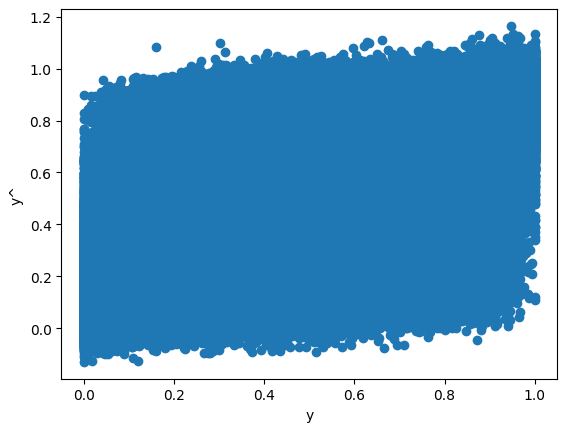


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.008941967980479427
RMSE 0.09456197957149283
MAE: 0.05939220089304241
R^2:  0.8710442988582237



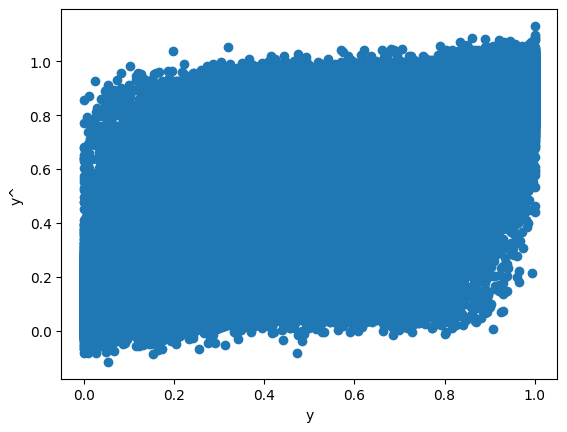


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.013933886181893099
RMSE 0.11804188316819204
MAE: 0.07893765816828933
R^2:  0.8094805357275153



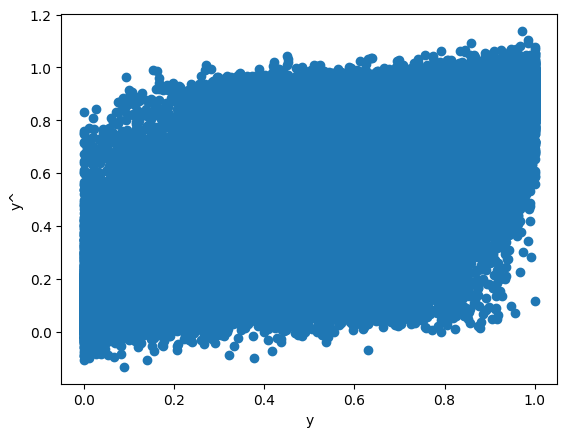

CPU times: user 18.8 s, sys: 18.5 s, total: 37.4 s
Wall time: 20.3 s


{'train': mse_t     0.012905
 rmse_t    0.113601
 mae_t     0.074545
 r2_t       0.82374
 dtype: object,
 'test': mse_t     0.008942
 rmse_t    0.094562
 mae_t     0.059392
 r2_t      0.871044
 mse_v     0.013934
 rmse_v    0.118042
 mae_v     0.078938
 r2_v      0.809481
 dtype: object}

In [27]:
%%time 

test_model_train_val_test(
    lin_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.9s finished



  model test
Scores: [-0.11558634 -0.11541634 -0.11693974 -0.11855586 -0.11879798]
Mean: -0.11705925267850711
Standard deviation: 0.0014244941427146323

Training time: 0.095 s
----- EVALUATION ON VAL SET ------
MSE: 0.013699732716607986
RMSE 0.11704585732356351
MAE: 0.07924787345385471
R^2:  0.8128877618496093



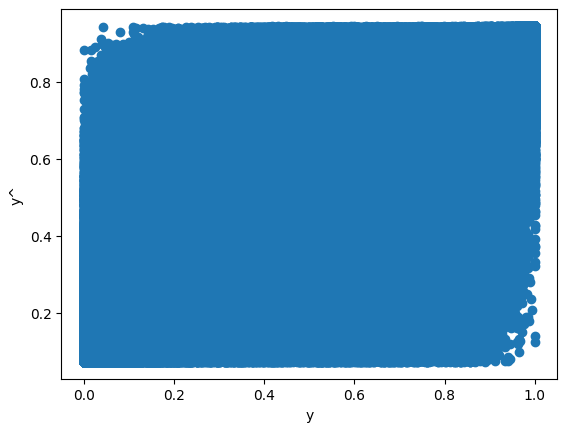


Training time: 0.028 s
----- EVALUATION ON VAL SET ------
MSE: 0.009821850766853117
RMSE 0.09910525095499792
MAE: 0.06555531868412684
R^2:  0.8583551568385811



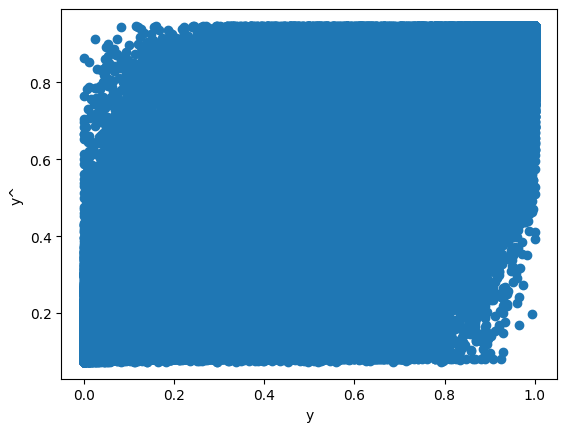


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.01472961113720383
RMSE 0.121365609367744
MAE: 0.08339452832727937
R^2:  0.7986005062644462



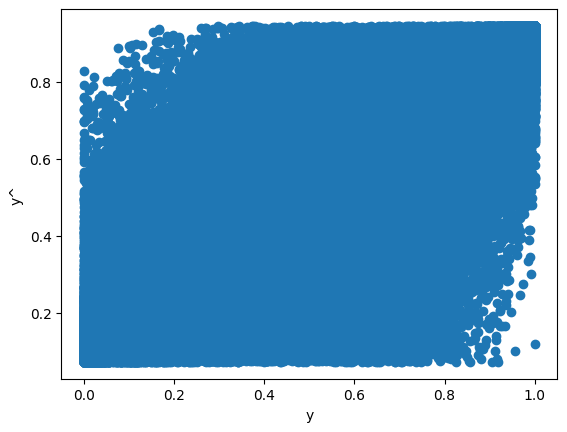

CPU times: user 13.2 s, sys: 5.49 s, total: 18.7 s
Wall time: 12.7 s


{'train': mse_t       0.0137
 rmse_t    0.117046
 mae_t     0.079248
 r2_t      0.812888
 dtype: object,
 'test': mse_t     0.009822
 rmse_t    0.099105
 mae_t     0.065555
 r2_t      0.858355
 mse_v      0.01473
 rmse_v    0.121366
 mae_v     0.083395
 r2_v      0.798601
 dtype: object}

In [28]:
%%time 

test_model_train_val_test(
    lasso_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s finished



  model test
Scores: [-0.11166495 -0.11151506 -0.11362028 -0.11551743 -0.11575026]
Mean: -0.11361359928184152
Standard deviation: 0.00181058094851334

Training time: 0.097 s
----- EVALUATION ON VAL SET ------
MSE: 0.012905136800137594
RMSE 0.11360077816695445
MAE: 0.07454537419775233
R^2:  0.8237404276228397



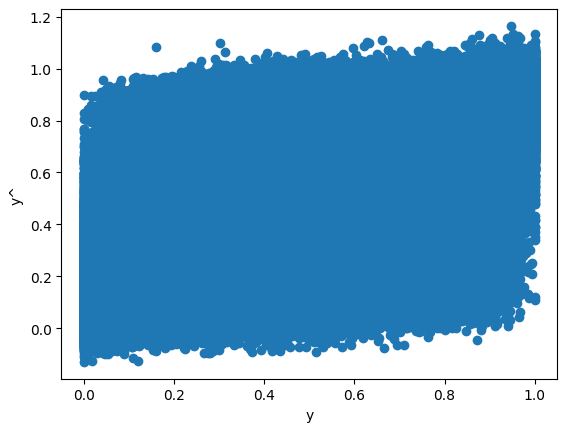


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.008941986551667816
RMSE 0.0945620777672943
MAE: 0.0593925094078251
R^2:  0.8710440310356788



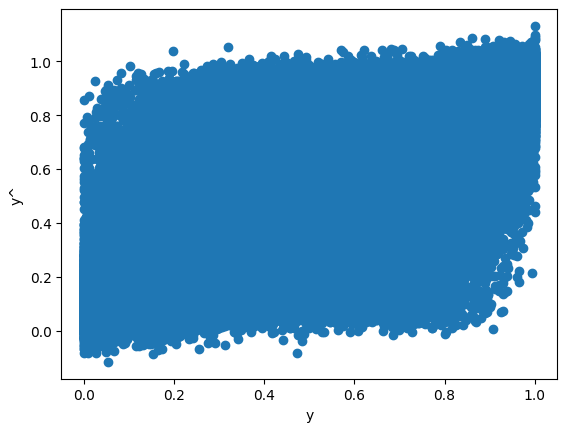


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.013933883772851468
RMSE 0.11804187296400998
MAE: 0.07893751378190234
R^2:  0.8094805686665902



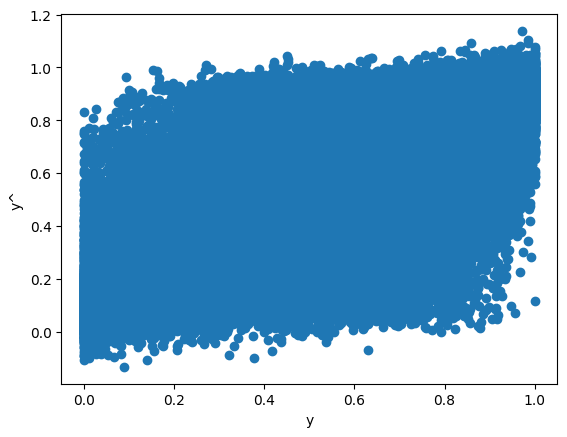

CPU times: user 10.9 s, sys: 4.65 s, total: 15.6 s
Wall time: 10.3 s


{'train': mse_t     0.012905
 rmse_t    0.113601
 mae_t     0.074545
 r2_t       0.82374
 dtype: object,
 'test': mse_t     0.008942
 rmse_t    0.094562
 mae_t     0.059393
 r2_t      0.871044
 mse_v     0.013934
 rmse_v    0.118042
 mae_v     0.078938
 r2_v      0.809481
 dtype: object}

In [29]:
%%time 

test_model_train_val_test(
    ridge_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.3s remaining:   13.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.5s finished



  model test
Scores: [-0.11402518 -0.11387279 -0.11560933 -0.1173843  -0.11764193]
Mean: -0.11570670602735504
Standard deviation: 0.0015974769697069742

Training time: 0.103 s
----- EVALUATION ON VAL SET ------
MSE: 0.013384990745667447
RMSE 0.1156935207592346
MAE: 0.07683718048833174
R^2:  0.8171865372958744



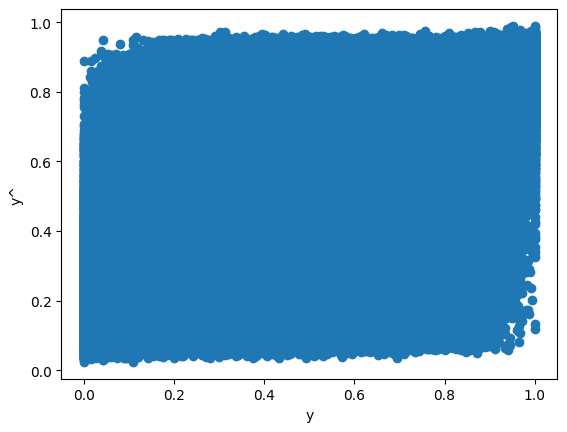


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.009485369965622398
RMSE 0.09739286403850335
MAE: 0.06284686141119913
R^2:  0.8632076812200348



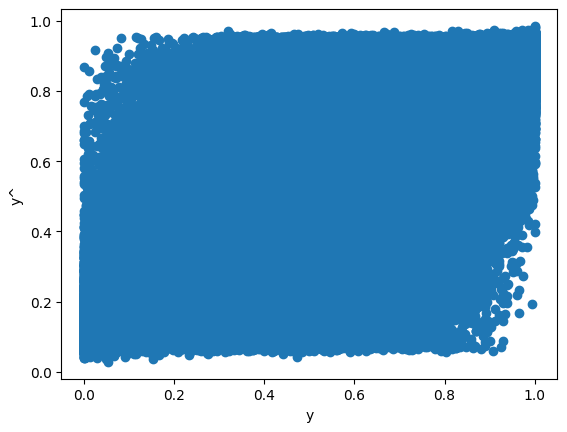


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.014418843773090384
RMSE 0.12007849005167572
MAE: 0.08114910192830199
R^2:  0.802849660516991



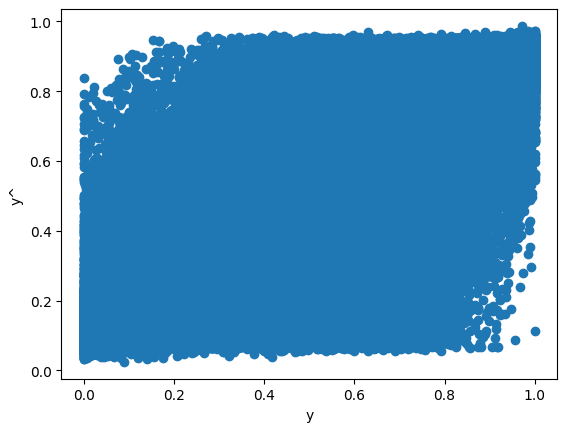

CPU times: user 35.3 s, sys: 10.3 s, total: 45.6 s
Wall time: 19.8 s


{'train': mse_t     0.013385
 rmse_t    0.115694
 mae_t     0.076837
 r2_t      0.817187
 dtype: object,
 'test': mse_t     0.009485
 rmse_t    0.097393
 mae_t     0.062847
 r2_t      0.863208
 mse_v     0.014419
 rmse_v    0.120078
 mae_v     0.081149
 r2_v       0.80285
 dtype: object}

In [30]:
%%time 

test_model_train_val_test(
    elasticNet_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


## KNN3
### Not ideal to store and sort large data.
https://www.kaggle.com/general/352216

## SVM 
### SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. 
https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python#advantages

## Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor

In [56]:
%%time 

# define model 
tree_reg = DecisionTreeRegressor(
    criterion='friedman_mse',
    max_depth=12, 
    random_state=config.seed
)


CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 23.4 µs


### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   51.2s remaining:  1.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   51.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   51.9s finished



  model test
Scores: [-0.10715108 -0.10703776 -0.10914086 -0.11120652 -0.11138029]
Mean: -0.1091833029094543
Standard deviation: 0.0018791105968966383

Training time: 0.439 s
----- EVALUATION ON VAL SET ------
MSE: 0.011561245740577038
RMSE 0.10752323349200878
MAE: 0.06970079963488081
R^2:  0.8420954181315112



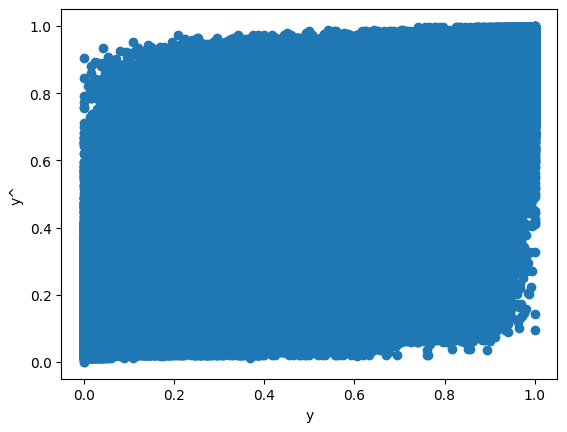


Training time: 0.104 s
----- EVALUATION ON VAL SET ------
MSE: 0.00873883351059196
RMSE 0.09348172821782855
MAE: 0.057321347108693216
R^2:  0.8739737823955821



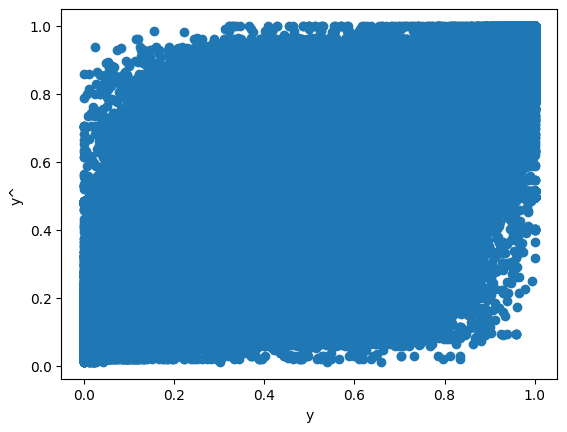


Testing time: 0.04 s
----- EVALUATION ON VAL SET ------
MSE: 0.012954061600047589
RMSE 0.11381591101444292
MAE: 0.07558981712914724
R^2:  0.8228777783902838



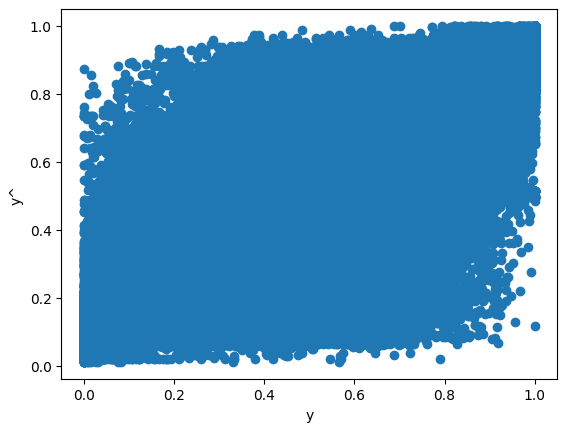

CPU times: user 1min 5s, sys: 1.85 s, total: 1min 7s
Wall time: 1min 57s


{'train': mse_t     0.011561
 rmse_t    0.107523
 mae_t     0.069701
 r2_t      0.842095
 dtype: object,
 'test': mse_t     0.008739
 rmse_t    0.093482
 mae_t     0.057321
 r2_t      0.873974
 mse_v     0.012954
 rmse_v    0.113816
 mae_v      0.07559
 r2_v      0.822878
 dtype: object}

In [57]:
%%time 

test_model_train_val_test(
    tree_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


### Testing each month

In [58]:
%%time 

result = do_test_per_month(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=12, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021, 2022],
    months
)

  0%|          | 0/14 [00:00<?, ?months/s]

CPU times: user 49.2 s, sys: 15.8 ms, total: 49.3 s
Wall time: 49.3 s


In [59]:
result

,order_,mae_t_test,mae_t_train,mae_v_test,mae_v_train,mse_t_test,mse_t_train,mse_v_test,mse_v_train,r2_t_test,r2_t_train,r2_v_test,r2_v_train,rmse_t_test,rmse_t_train,rmse_v_test,rmse_v_train
0,0,0.062646,0.058257,0.084839,NaN,0.011217,0.008772,0.016764,NaN,0.828368,0.87452,0.770789,NaN,0.105911,0.093658,0.129475,NaN
1,1,0.065679,0.063789,0.083888,NaN,0.014095,0.009967,0.016543,NaN,0.813384,0.879183,0.77381,NaN,0.118724,0.099835,0.128618,NaN
2,2,0.067123,0.064489,0.083781,NaN,0.014349,0.010224,0.016351,NaN,0.812553,0.877989,0.77643,NaN,0.119788,0.101114,0.127871,NaN
3,3,0.062667,0.062931,0.083618,NaN,0.011436,0.009934,0.016268,NaN,0.853648,0.882984,0.777566,NaN,0.106938,0.09967,0.127546,NaN
4,4,0.063296,0.066703,0.083191,NaN,0.011295,0.010625,0.016288,NaN,0.85921,0.880399,0.777293,NaN,0.106279,0.103078,0.127624,NaN
5,5,0.06272,0.066411,0.082415,NaN,0.010774,0.010231,0.01586,NaN,0.843745,0.855747,0.783147,NaN,0.103796,0.101146,0.125936,NaN
6,6,0.060898,0.060983,0.083967,NaN,0.010255,0.008814,0.01653,NaN,0.83974,0.860764,0.77398,NaN,0.101266,0.093882,0.12857,NaN
7,7,0.063002,0.064226,0.085723,NaN,0.010914,0.009739,0.016414,NaN,0.815068,0.840329,0.775574,NaN,0.104468,0.098686,0.128116,NaN
8,8,0.070682,0.072424,0.084653,NaN,0.013344,0.011753,0.01665,NaN,0.810305,0.834687,0.772343,NaN,0.115518,0.108412,0.129035,NaN
9,9,0.071045,0.070797,0.084096,NaN,0.01297,0.011292,0.015953,NaN,0.80046,0.826308,0.781868,NaN,0.113886,0.106263,0.126307,NaN


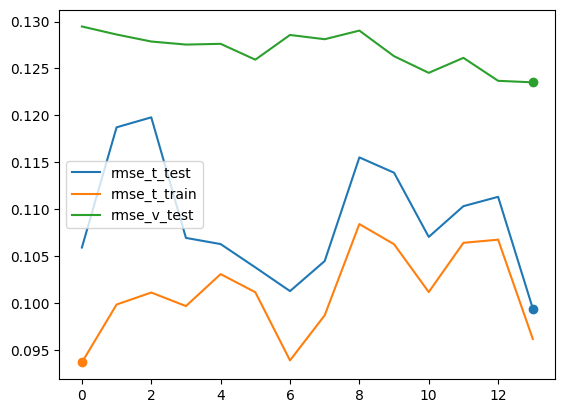

In [60]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [61]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()


rmse_t_test     0.099411
rmse_t_train    0.093658
rmse_v_test      0.12352
dtype: object

In [62]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()


r2_t_test      0.85921
r2_t_train    0.882984
r2_v_test     0.791387
dtype: object

### Testing combination of three consecutive months

In [63]:
%%time

result = do_test_per_month_combos(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=12, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

  0%|          | 0/14 [00:00<?, ?months/s]

CPU times: user 2min 18s, sys: 4.13 ms, total: 2min 18s
Wall time: 2min 18s


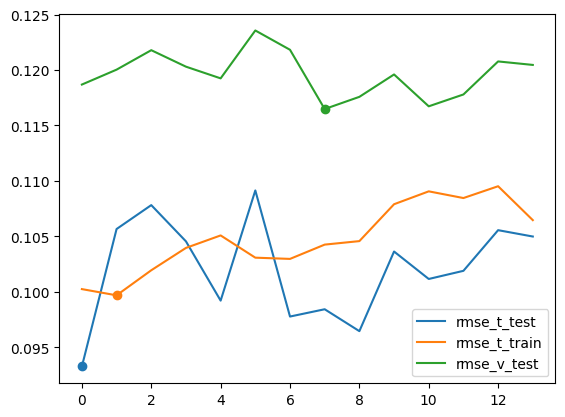

In [64]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [65]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()


rmse_t_test     0.093267
rmse_t_train    0.099683
rmse_v_test     0.116482
dtype: object

In [66]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()


r2_t_test     0.876389
r2_t_train    0.874299
r2_v_test     0.814484
dtype: object

[CV] END .................................................... total time=  49.6s
[CV] END .................................................... total time=  50.3s
[CV] END .................................................... total time=  50.7s
[CV] END .................................................... total time=  50.8s
[CV] END .................................................... total time=  50.9s


### Fine tuning parameters

In [43]:
# define model 
tree_reg = DecisionTreeRegressor(criterion='friedman_mse', random_state=config.seed)

param_grid = [
    {
        'max_depth':[8, 9, 10, 11, 12, 13]
    }
]

grid_search = GridSearchCV(
    tree_reg, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [44]:
grid_search.fit(X_train_prepared, y_train_prepared)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................................max_depth=8; total time=  34.1s
[CV] END ........................................max_depth=8; total time=  34.5s
[CV] END ........................................max_depth=8; total time=  34.4s
[CV] END ........................................max_depth=8; total time=  34.6s
[CV] END ........................................max_depth=8; total time=  34.5s
[CV] END ........................................max_depth=9; total time=  37.5s
[CV] END ........................................max_depth=9; total time=  38.4s
[CV] END ........................................max_depth=9; total time=  38.7s
[CV] END ........................................max_depth=9; total time=  37.0s
[CV] END ........................................max_depth=9; total time=  36.9s
[CV] END .......................................max_depth=10; total time=  39.2s
[CV] END .......................................m

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                             random_state=42),
             param_grid=[{'max_depth': [8, 9, 10, 11, 12, 13]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [45]:

print("the best parameters are:")
print(grid_search.best_params_)


the best parameters are:
{'max_depth': 12}


In [46]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


DecisionTreeRegressor(criterion='friedman_mse', max_depth=12, random_state=42)

In [47]:
print("Best Score")
-grid_search.best_score_

Best Score


0.1091833029094543

In [48]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.11123987737024602 {'max_depth': 8}
0.11045368198067747 {'max_depth': 9}
0.1098171813435489 {'max_depth': 10}
0.1093731745256125 {'max_depth': 11}
0.1091833029094543 {'max_depth': 12}
0.10932679581082005 {'max_depth': 13}


In [49]:
results = grid_search.cv_results_

In [51]:
results

{'mean_fit_time': array([34.35725217, 37.64591603, 39.25999374, 41.98958454, 44.86360693,
        47.24010792]),
 'std_fit_time': array([0.1880694 , 0.72855779, 0.34509869, 0.18553055, 0.22876044,
        0.42666296]),
 'mean_score_time': array([0.06127453, 0.0679986 , 0.07609491, 0.0830843 , 0.09148617,
        0.09783635]),
 'std_score_time': array([0.00079588, 0.00108344, 0.00070637, 0.00067302, 0.00170417,
        0.00057703]),
 'param_max_depth': masked_array(data=[8, 9, 10, 11, 12, 13],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10},
  {'max_depth': 11},
  {'max_depth': 12},
  {'max_depth': 13}],
 'split0_test_score': array([-0.10931604, -0.10846211, -0.10779018, -0.10734557, -0.10715108,
        -0.10730265]),
 'split1_test_score': array([-0.10916636, -0.10835287, -0.10767338, -0.10727481, -0.10703776,
        -0.10723041]),
 'split2_test_scor

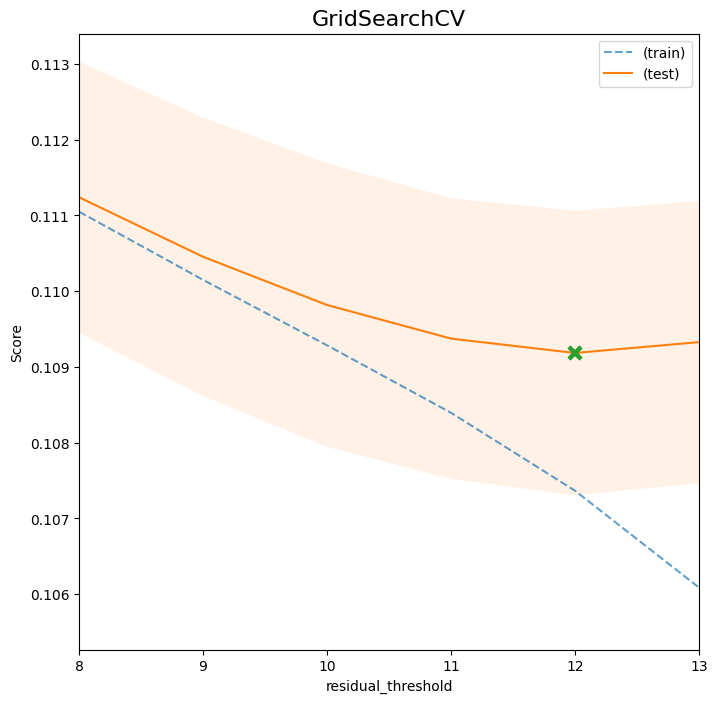

In [54]:
print_grid_result(results, 'param_max_depth')

## Random Forest

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [150]:
%%time 

# define used regressor
forest=RandomForestRegressor(n_estimators=80,
                             max_depth=12,
                             criterion='friedman_mse',
                             n_jobs=10,
                             random_state=config.seed
                            )

CPU times: user 94 µs, sys: 0 ns, total: 94 µs
Wall time: 99.9 µs


### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 24.7min remaining: 37.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 24.7min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 24.7min finished



  model test
Scores: [-0.10560692 -0.10548037 -0.10754454 -0.10962074 -0.10973015]
Mean: -0.10759654500566129
Standard deviation: 0.0018487366907725782
[CV] END .................................................... total time=24.6min
[CV] END .................................................... total time=24.7min
[CV] END .................................................... total time=24.7min
[CV] END .................................................... total time=24.7min
[CV] END .................................................... total time=24.7min

Training time: 3.063 s
----- EVALUATION ON VAL SET ------
MSE: 0.011283559993231286
RMSE 0.106224102694404
MAE: 0.06872539269182538
R^2:  0.8458880761901125



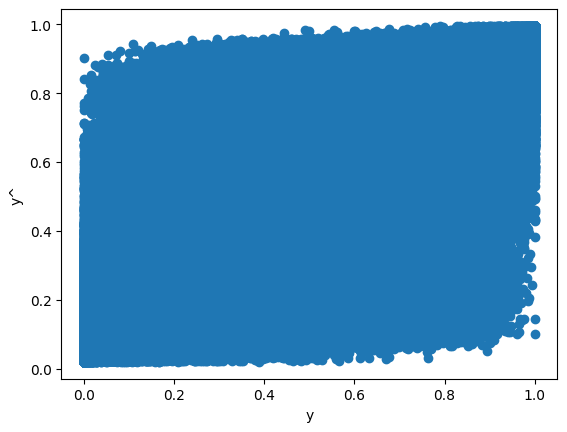


Training time: 0.749 s
----- EVALUATION ON VAL SET ------
MSE: 0.008132040882346866
RMSE 0.09017782921731297
MAE: 0.05590344408551197
R^2:  0.8827245818833267



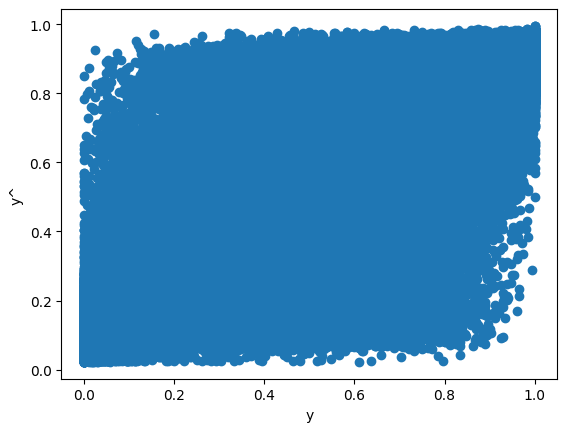


Testing time: 0.304 s
----- EVALUATION ON VAL SET ------
MSE: 0.012527552286041486
RMSE 0.11192654862025134
MAE: 0.0744211897379597
R^2:  0.8287094842726859



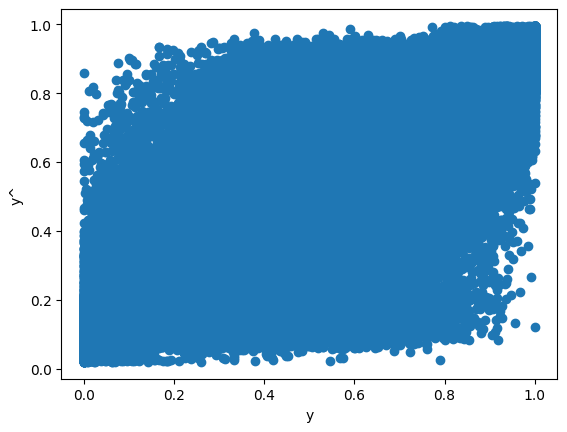

CPU times: user 1h 7min 20s, sys: 2.37 s, total: 1h 7min 22s
Wall time: 31min 49s


{'train': mse_t     0.011284
 rmse_t    0.106224
 mae_t     0.068725
 r2_t      0.845888
 dtype: object,
 'test': mse_t     0.008132
 rmse_t    0.090178
 mae_t     0.055903
 r2_t      0.882725
 mse_v     0.012528
 rmse_v    0.111927
 mae_v     0.074421
 r2_v      0.828709
 dtype: object}

In [151]:
%%time

test_model_train_val_test(
    forest, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

### Testing each month

In [152]:
%%time 

result = do_test_per_month(
    RandomForestRegressor, dict(n_estimators=80, max_depth=12, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021, 2022],
    months
)

  0%|          | 0/14 [00:00<?, ?months/s]

CPU times: user 44min 55s, sys: 1.49 s, total: 44min 56s
Wall time: 4min 45s


In [153]:
result

,order_,mae_t_test,mae_t_train,mae_v_test,mae_v_train,mse_t_test,mse_t_train,mse_v_test,mse_v_train,r2_t_test,r2_t_train,r2_v_test,r2_v_train,rmse_t_test,rmse_t_train,rmse_v_test,rmse_v_train
0,0,0.05337,0.056741,0.078173,NaN,0.007404,0.008177,0.013382,NaN,0.886705,0.88303,0.817027,NaN,0.086049,0.090427,0.11568,NaN
1,1,0.059291,0.061704,0.077857,NaN,0.008665,0.009186,0.013388,NaN,0.885276,0.888655,0.816939,NaN,0.093088,0.095842,0.115708,NaN
2,2,0.058641,0.062549,0.077611,NaN,0.00841,0.009459,0.013295,NaN,0.890143,0.887116,0.818217,NaN,0.091704,0.097259,0.115304,NaN
3,3,0.056734,0.060885,0.077298,NaN,0.008325,0.009155,0.013374,NaN,0.893457,0.892161,0.817139,NaN,0.091242,0.095682,0.115645,NaN
4,4,0.058496,0.064685,0.076968,NaN,0.008487,0.009829,0.013218,NaN,0.894217,0.889358,0.819265,NaN,0.092124,0.099142,0.114971,NaN
5,5,0.058414,0.064462,0.077132,NaN,0.008396,0.009488,0.013051,NaN,0.878231,0.866221,0.821558,NaN,0.091628,0.097405,0.114239,NaN
6,6,0.055966,0.059426,0.07856,NaN,0.007826,0.008224,0.013304,NaN,0.8777,0.870081,0.818093,NaN,0.088463,0.090687,0.115343,NaN
7,7,0.059128,0.062644,0.080266,NaN,0.008393,0.009077,0.013475,NaN,0.857782,0.851176,0.815748,NaN,0.091612,0.095275,0.116084,NaN
8,8,0.06596,0.070371,0.079286,NaN,0.009894,0.010881,0.013102,NaN,0.859356,0.846948,0.820853,NaN,0.099468,0.104314,0.114465,NaN
9,9,0.064273,0.068897,0.078544,NaN,0.009397,0.010492,0.013009,NaN,0.855435,0.838612,0.822132,NaN,0.096936,0.10243,0.114055,NaN


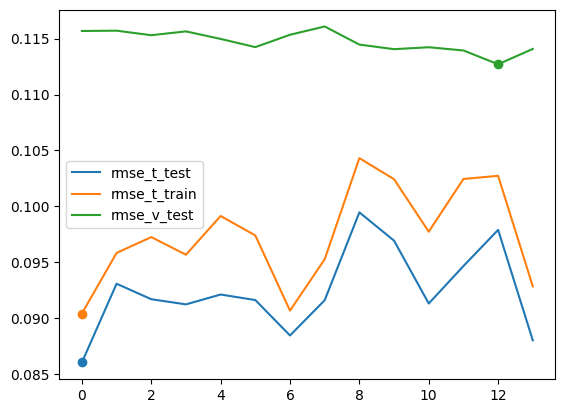

In [154]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [155]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()


rmse_t_test     0.086049
rmse_t_train    0.090427
rmse_v_test     0.112708
dtype: object

In [156]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()


r2_t_test     0.894217
r2_t_train    0.892161
r2_v_test     0.826308
dtype: object

### Testing combination of three consecutive months

In [ ]:
%%time

result = do_test_per_month_combos(
    RandomForestRegressor, dict(n_estimators=80, max_depth=12, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

  0%|          | 0/14 [00:00<?, ?months/s]

In [ ]:
result

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()


In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()


### Fine tuning parameters

In [92]:
Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2022], [2,3,4], True)

train
X (869116, 34) X_prepared: (869116, 23) y:  (869116,)
val
X (215285, 34) X_prepared: (215285, 23) y:  (215285,)
test
X (358887, 34) X_prepared: (358887, 23) y:  (358887,)


In [94]:
# define model 
forest_reg = RandomForestRegressor(criterion='friedman_mse', n_jobs=10, random_state=config.seed)

param_grid = [
    {
        'max_depth':[9, 11, 12, 14],
        'n_estimators':[80, 100, 120, 140]
    }
]

grid_search = GridSearchCV(
    forest_reg, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [95]:
grid_search.fit(Xtr, ytr)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................max_depth=9, n_estimators=80; total time=  45.6s
[CV] END .......................max_depth=9, n_estimators=80; total time=  45.2s
[CV] END .......................max_depth=9, n_estimators=80; total time=  44.9s
[CV] END .......................max_depth=9, n_estimators=80; total time=  44.5s
[CV] END .......................max_depth=9, n_estimators=80; total time=  44.4s
[CV] END ......................max_depth=9, n_estimators=100; total time=  56.6s
[CV] END ......................max_depth=9, n_estimators=100; total time=  55.9s
[CV] END ......................max_depth=9, n_estimators=100; total time=  56.3s
[CV] END ......................max_depth=9, n_estimators=100; total time=  54.6s
[CV] END ......................max_depth=9, n_estimators=100; total time=  55.5s
[CV] END ......................max_depth=9, n_estimators=120; total time= 1.1min
[CV] END ......................max_depth=9, n_es

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestRegressor(criterion='friedman_mse',
                                             n_jobs=10, random_state=42),
             param_grid=[{'max_depth': [9, 11, 12, 14],
                          'n_estimators': [80, 100, 120, 140]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [96]:

print("the best parameters are:")
print(grid_search.best_params_)


the best parameters are:
{'max_depth': 14, 'n_estimators': 140}


In [97]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


RandomForestRegressor(criterion='friedman_mse', max_depth=14, n_estimators=140,
                      n_jobs=10, random_state=42)

In [98]:
print("Best Score")
-grid_search.best_score_

Best Score


0.11060082035084232

In [99]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.11312019281723258 {'max_depth': 9, 'n_estimators': 80}
0.1131153201923952 {'max_depth': 9, 'n_estimators': 100}
0.11311570327371678 {'max_depth': 9, 'n_estimators': 120}
0.11311458907739358 {'max_depth': 9, 'n_estimators': 140}
0.11179039653442754 {'max_depth': 11, 'n_estimators': 80}
0.11177784651198894 {'max_depth': 11, 'n_estimators': 100}
0.11177183542929905 {'max_depth': 11, 'n_estimators': 120}
0.11176954969526279 {'max_depth': 11, 'n_estimators': 140}
0.11130206935511497 {'max_depth': 12, 'n_estimators': 80}
0.11128803267752127 {'max_depth': 12, 'n_estimators': 100}
0.11127742022098042 {'max_depth': 12, 'n_estimators': 120}
0.11127356454224886 {'max_depth': 12, 'n_estimators': 140}
0.11065434509074172 {'max_depth': 14, 'n_estimators': 80}
0.11063278435402232 {'max_depth': 14, 'n_estimators': 100}
0.1106146290304589 {'max_depth': 14, 'n_estimators': 120}
0.11060082035084232 {'max_depth': 14, 'n_estimators': 140}


In [100]:
results = grid_search.cv_results_

In [101]:
results

{'mean_fit_time': array([ 44.82427268,  55.67862496,  66.42327671,  78.51100059,
         50.49500747,  63.03789134,  75.67968469,  87.93199363,
         53.56699214,  66.91695976,  80.70367684,  93.39283838,
         59.60321627,  74.45733733,  90.28067226, 105.60762377]),
 'std_fit_time': array([0.46109376, 0.69385273, 0.34827997, 1.28276522, 0.16417406,
        0.313982  , 0.0915981 , 0.26323011, 0.07838313, 0.17022583,
        0.61208562, 0.31616916, 0.03904341, 0.12557228, 0.63565711,
        0.22869399]),
 'mean_score_time': array([0.1031497 , 0.12836046, 0.14992757, 0.16933355, 0.13239489,
        0.16306748, 0.18603754, 0.21451821, 0.14363699, 0.17956781,
        0.2178266 , 0.24262924, 0.18599267, 0.22513204, 0.26422796,
        0.30895948]),
 'std_score_time': array([0.00403886, 0.00187553, 0.00273468, 0.00193546, 0.00423982,
        0.00575699, 0.00380152, 0.00516266, 0.00339606, 0.00536695,
        0.00255044, 0.004951  , 0.00645163, 0.00775509, 0.00734728,
        0.003386

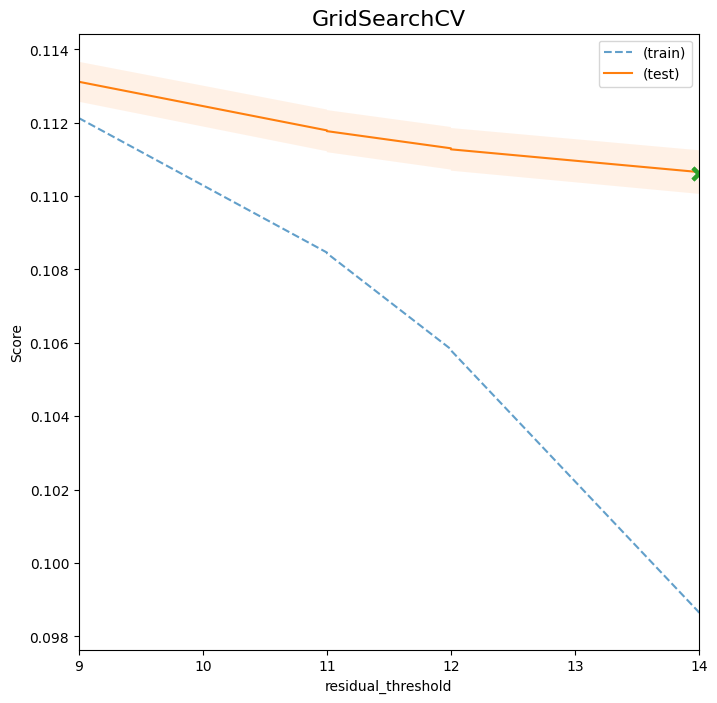

In [102]:
print_grid_result(results, 'param_max_depth')

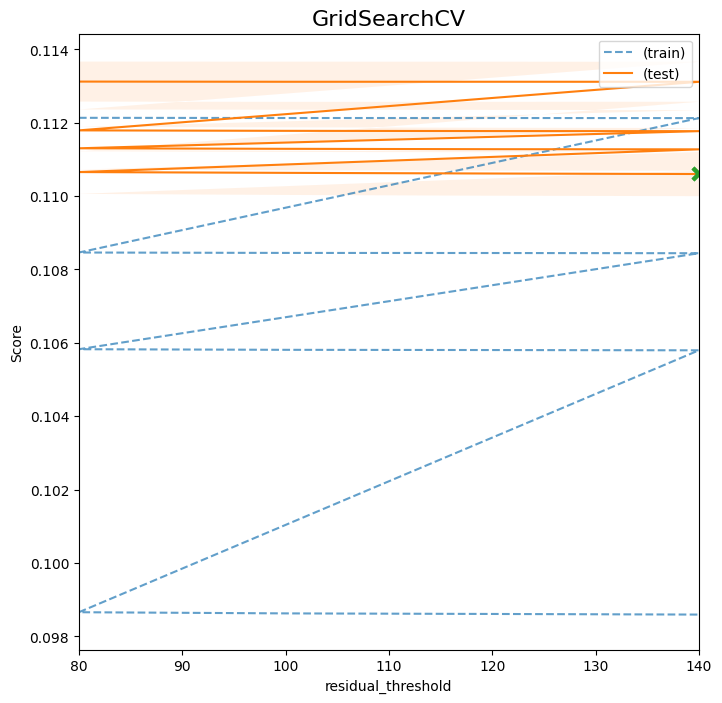

In [103]:
print_grid_result(results, 'param_n_estimators')

## Gradiend Boosting

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
%%time 

boosting = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=12, 
    loss='squared_error',
    criterion='friedman_mse',
    random_state=config.seed,
    verbose=2,
    warm_start=True
)


CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 45.8 µs


### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 97.4min remaining: 146.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 97.8min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 97.8min finished



  model test
Scores: [-0.10062565 -0.10072965 -0.10223873 -0.10433193 -0.10441916]
Mean: -0.10246902498189722
Standard deviation: 0.0016583096534075006
      Iter       Train Loss   Remaining Time 
         1           0.0615          105.36m
         2           0.0520          104.26m
         3           0.0443          103.23m
         4           0.0380          102.12m
      Iter       Train Loss   Remaining Time 
         1           0.0624           91.29m
         2           0.0527           89.92m
         3           0.0448           88.75m
         4           0.0384           87.70m
         5           0.0333           86.76m
         6           0.0291           85.78m
         7           0.0256           84.89m
         8           0.0228           83.97m
         9           0.0206           83.08m
        10           0.0187           82.16m
        11           0.0172           81.26m
        12           0.0160           80.35m
        13           0.0150        

      Iter       Train Loss   Remaining Time 
         1           0.0605           92.15m
         2           0.0512           90.82m
         3           0.0436           89.75m
         4           0.0375           88.67m
         5           0.0326           87.62m
         6           0.0285           86.55m
         7           0.0252           85.61m
         8           0.0226           84.71m
         9           0.0204           83.80m
        10           0.0186           82.85m
        11           0.0172           81.86m
        12           0.0160           80.90m
        13           0.0150           79.96m
        14           0.0143           79.07m
        15           0.0136           78.17m
        16           0.0131           77.27m
        17           0.0126           76.41m
        18           0.0123           75.55m
        19           0.0120           74.70m
        20           0.0117           73.81m
        21           0.0115           72.93m
        2

      Iter       Train Loss   Remaining Time 
         1           0.0606           92.11m
         2           0.0513           90.54m
         3           0.0438           89.45m
         4           0.0376           88.37m
         5           0.0326           87.32m
         6           0.0286           86.40m
         7           0.0253           85.49m
         8           0.0226           84.55m
         9           0.0204           83.61m
        10           0.0187           82.72m
        11           0.0172           81.86m
        12           0.0160           80.99m
        13           0.0151           80.09m
        14           0.0143           79.21m
        15           0.0136           78.32m
        16           0.0131           77.42m
        17           0.0126           76.54m
        18           0.0123           75.64m
        19           0.0120           74.76m
        20           0.0117           73.86m
        21           0.0115           72.98m
        2

        85           0.0092           15.99m
        86           0.0092           14.93m
        87           0.0091           13.88m
        88           0.0091           12.82m
        89           0.0091           11.77m
        90           0.0091           10.70m
        91           0.0091            9.64m
        92           0.0091            8.57m
        93           0.0091            7.51m
        94           0.0091            6.43m
        95           0.0091            5.36m
        96           0.0090            4.29m
        97           0.0090            3.22m
        98           0.0090            2.15m
        99           0.0090            1.07m
       100           0.0090            0.00s

Training time: 21.87 s
----- EVALUATION ON VAL SET ------
MSE: 0.008995961348346794
RMSE 0.0948470418534326
MAE: 0.061905992084698755
R^2:  0.877132313671858



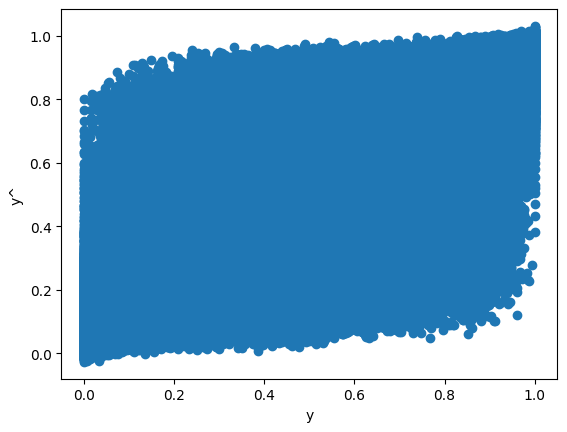


Training time: 5.151 s
----- EVALUATION ON VAL SET ------
MSE: 0.008347438194675146
RMSE 0.09136431576209142
MAE: 0.059406963156159384
R^2:  0.8796182509843584



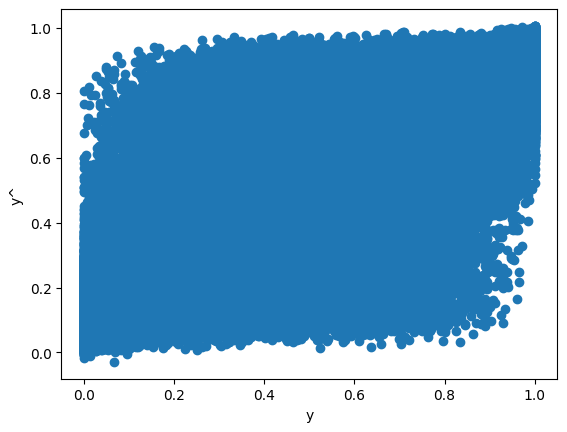


Testing time: 1.811 s
----- EVALUATION ON VAL SET ------
MSE: 0.011567562780066841
RMSE 0.10755260471075
MAE: 0.07193525480313485
R^2:  0.8418355198953371



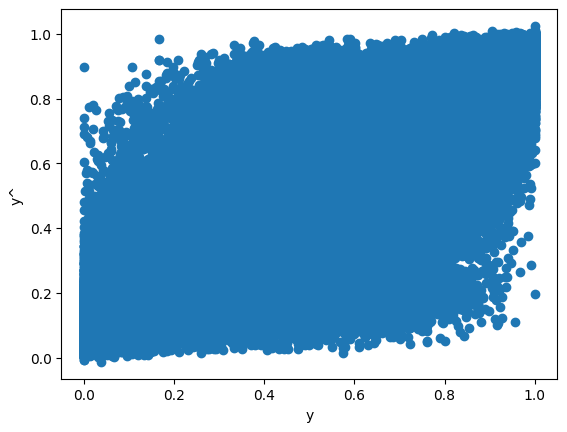

CPU times: user 1h 47min 56s, sys: 2.09 s, total: 1h 47min 58s
Wall time: 3h 25min 43s


{'train': mse_t     0.008996
 rmse_t    0.094847
 mae_t     0.061906
 r2_t      0.877132
 dtype: object,
 'test': mse_t     0.008347
 rmse_t    0.091364
 mae_t     0.059407
 r2_t      0.879618
 mse_v     0.011568
 rmse_v    0.107553
 mae_v     0.071935
 r2_v      0.841836
 dtype: object}

In [51]:
%%time 

test_model_train_val_test(
    boosting, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

### Testing each month

In [107]:
%%time 

result = do_test_per_month(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=0
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    months
)


  0%|          | 0/14 [00:00<?, ?months/s]

CPU times: user 1h 12min 54s, sys: 159 ms, total: 1h 12min 54s
Wall time: 1h 12min 54s


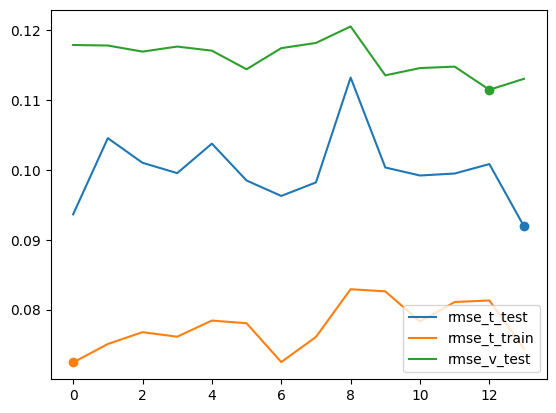

In [108]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [109]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.091915
rmse_t_train    0.072428
rmse_v_test     0.111497
dtype: object

In [110]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.873156
r2_t_train    0.931748
r2_v_test     0.830023
dtype: object

### Testing combination of three consecutive months

In [111]:
%%time 

result = do_test_per_month_combos(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=2
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

  0%|          | 0/14 [00:00<?, ?months/s]

      Iter       Train Loss   Remaining Time 
         1           0.0571           16.57m
         2           0.0482           16.36m
         3           0.0410           16.18m
         4           0.0351           16.01m
         5           0.0304           15.85m
         6           0.0265           15.69m
         7           0.0234           15.54m
         8           0.0208           15.38m
         9           0.0187           15.21m
        10           0.0170           15.05m
        11           0.0156           14.89m
        12           0.0145           14.72m
        13           0.0135           14.55m
        14           0.0128           14.38m
        15           0.0121           14.22m
        16           0.0116           14.05m
        17           0.0112           13.88m
        18           0.0108           13.72m
        19           0.0105           13.55m
        20           0.0103           13.39m
        21           0.0101           13.22m
        2

        82           0.0075            3.05m
        83           0.0075            2.88m
        84           0.0074            2.71m
        85           0.0074            2.54m
        86           0.0074            2.37m
        87           0.0074            2.21m
        88           0.0074            2.04m
        89           0.0074            1.87m
        90           0.0073            1.70m
        91           0.0073            1.53m
        92           0.0073            1.36m
        93           0.0073            1.19m
        94           0.0073            1.02m
        95           0.0073           51.23s
        96           0.0073           41.03s
        97           0.0073           30.82s
        98           0.0073           20.58s
        99           0.0072           10.29s
       100           0.0072            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0657           15.93m
         2           0.0553           15.71m
         

        63           0.0083            6.07m
        64           0.0083            5.92m
        65           0.0083            5.76m
        66           0.0083            5.60m
        67           0.0082            5.45m
        68           0.0082            5.29m
        69           0.0082            5.13m
        70           0.0082            4.97m
        71           0.0082            4.81m
        72           0.0082            4.65m
        73           0.0081            4.50m
        74           0.0081            4.33m
        75           0.0081            4.17m
        76           0.0081            4.01m
        77           0.0081            3.86m
        78           0.0081            3.70m
        79           0.0081            3.53m
        80           0.0080            3.37m
        81           0.0080            3.20m
        82           0.0080            3.04m
        83           0.0080            2.87m
        84           0.0080            2.71m
        85

        44           0.0082            5.61m
        45           0.0082            5.52m
        46           0.0082            5.42m
        47           0.0081            5.32m
        48           0.0081            5.22m
        49           0.0080            5.13m
        50           0.0080            5.03m
        51           0.0080            4.93m
        52           0.0079            4.83m
        53           0.0079            4.74m
        54           0.0079            4.65m
        55           0.0079            4.55m
        56           0.0078            4.45m
        57           0.0078            4.36m
        58           0.0078            4.26m
        59           0.0077            4.16m
        60           0.0077            4.07m
        61           0.0077            3.97m
        62           0.0077            3.87m
        63           0.0077            3.77m
        64           0.0076            3.67m
        65           0.0076            3.58m
        66

        25           0.0102           12.55m
        26           0.0101           12.38m
        27           0.0100           12.21m
        28           0.0099           12.05m
        29           0.0099           11.88m
        30           0.0098           11.72m
        31           0.0097           11.56m
        32           0.0096           11.39m
        33           0.0096           11.22m
        34           0.0095           11.06m
        35           0.0095           10.89m
        36           0.0094           10.73m
        37           0.0094           10.57m
        38           0.0093           10.40m
        39           0.0093           10.24m
        40           0.0092           10.08m
        41           0.0092            9.92m
        42           0.0091            9.76m
        43           0.0091            9.60m
        44           0.0091            9.44m
        45           0.0090            9.28m
        46           0.0090            9.11m
        47

         6           0.0270           15.64m
         7           0.0241           15.47m
         8           0.0217           15.32m
         9           0.0197           15.15m
        10           0.0181           14.99m
        11           0.0168           14.82m
        12           0.0157           14.66m
        13           0.0149           14.49m
        14           0.0141           14.32m
        15           0.0135           14.16m
        16           0.0131           13.99m
        17           0.0126           13.83m
        18           0.0123           13.67m
        19           0.0120           13.50m
        20           0.0117           13.34m
        21           0.0115           13.18m
        22           0.0113           13.01m
        23           0.0112           12.84m
        24           0.0110           12.68m
        25           0.0109           12.51m
        26           0.0108           12.35m
        27           0.0107           12.18m
        28

        88           0.0088            2.12m
        89           0.0087            1.95m
        90           0.0087            1.77m
        91           0.0087            1.60m
        92           0.0087            1.42m
        93           0.0087            1.24m
        94           0.0087            1.07m
        95           0.0087           53.42s
        96           0.0087           42.78s
        97           0.0087           32.12s
        98           0.0086           21.41s
        99           0.0086           10.71s
       100           0.0086            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0583           17.30m
         2           0.0495           17.12m
         3           0.0424           16.94m
         4           0.0366           16.74m
         5           0.0319           16.56m
         6           0.0281           16.40m
         7           0.0250           16.22m
         8           0.0224           16.05m
         

        69           0.0088            3.38m
        70           0.0087            3.27m
        71           0.0087            3.17m
        72           0.0087            3.07m
        73           0.0087            2.96m
        74           0.0087            2.86m
        75           0.0086            2.75m
        76           0.0086            2.64m
        77           0.0086            2.54m
        78           0.0086            2.43m
        79           0.0086            2.32m
        80           0.0085            2.21m
        81           0.0085            2.10m
        82           0.0085            1.99m
        83           0.0085            1.88m
        84           0.0084            1.77m
        85           0.0084            1.66m
        86           0.0084            1.55m
        87           0.0084            1.45m
        88           0.0084            1.34m
        89           0.0084            1.23m
        90           0.0084            1.12m
        91

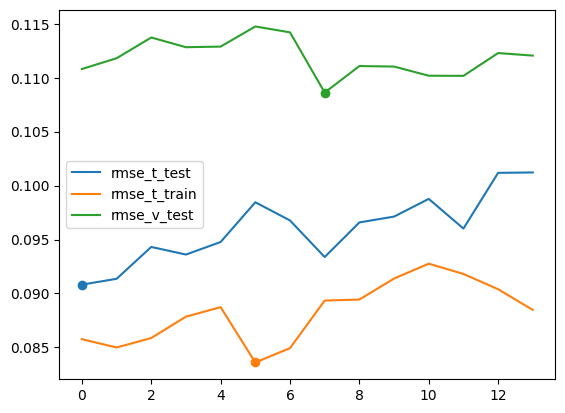

In [112]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [113]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.090821
rmse_t_train    0.083605
rmse_v_test     0.108619
dtype: object

In [114]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.885877
r2_t_train    0.915987
r2_v_test     0.838683
dtype: object

### Fine tuning parameters

In [ ]:
Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2022], [2,3,4], True)

In [ ]:
# define model 
boosting = GradientBoostingRegressor(loss='squared_error', criterion='friedman_mse', random_state=config.seed)

param_grid = [
    {
        'max_depth':[9, 11, 13, 15],
        'n_estimators':[60, 80, 110]
    }
]

grid_search = GridSearchCV(
    boosting, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [95]:
grid_search.fit(Xtr, ytr)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
      Iter       Train Loss   Remaining Time 
         1           0.0575            6.78m
         2           0.0490            6.66m
         3           0.0421            6.59m
         4           0.0365            6.45m
         5           0.0319            6.32m
         6           0.0283            6.20m
         7           0.0253            6.07m
         8           0.0228            5.97m
         9           0.0208            5.87m
        10           0.0192            5.75m
        11           0.0179            5.63m
        12           0.0168            5.51m
        13           0.0160            5.39m
        14           0.0152            5.27m
        15           0.0146            5.16m
        16           0.0142            5.05m
        17           0.0137            4.93m
        18           0.0134            4.81m
        19           0.0131            4.70m
        20           0.0129           

KeyboardInterrupt: 

In [99]:

print("the best parameters are:")
print(grid_search.best_params_)


the best parameters are:
{'max_depth': 9, 'n_estimators': 110}


In [100]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=0,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=110, n_jobs=10, num_parallel_tree=None,
             predictor='gpu_predictor', random_state=42, ...)

In [101]:
print("Best Score")
-grid_search.best_score_

Best Score


0.1063765398737431

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

In [ ]:
results = grid_search.cv_results_

In [ ]:
results

In [ ]:
print_grid_result(results, 'param_max_depth')

### XGBoost 

In [119]:

# check xgboost version
import xgboost
print(xgboost.__version__)


1.7.6


In [120]:
from xgboost import XGBRegressor

In [121]:
# create an xgboost regression model
xgboosting = XGBRegressor(
    n_estimators=160,
    max_depth=14, 
    max_leaves=0,
    verbosity=0,
    n_jobs=10,
    random_state=config.seed,
    booster='gbtree',
    predictor='gpu_predictor'
)

### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.1min remaining: 13.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.2min finished



  model test
Scores: [-0.1026789  -0.10281757 -0.10465573 -0.10668891 -0.1068084 ]
Mean: -0.10472990059101277
Standard deviation: 0.0017903621220286634

Training time: 0.699 s
----- EVALUATION ON VAL SET ------
MSE: 0.01082806262227737
RMSE 0.10405797721596058
MAE: 0.067458729261886
R^2:  0.8521093021303445



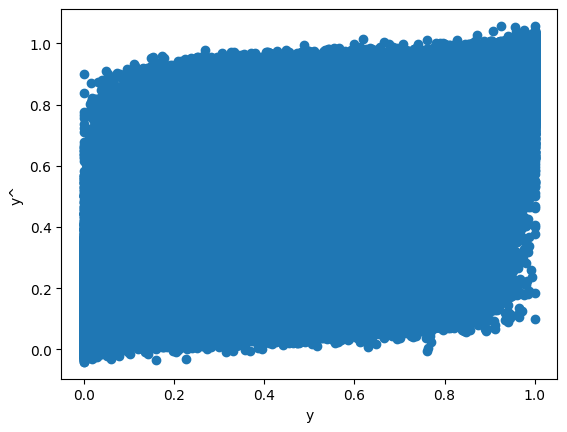


Training time: 0.18 s
----- EVALUATION ON VAL SET ------
MSE: 0.008057487844417982
RMSE 0.08976351065114366
MAE: 0.05666287421804607
R^2:  0.8837997410987651



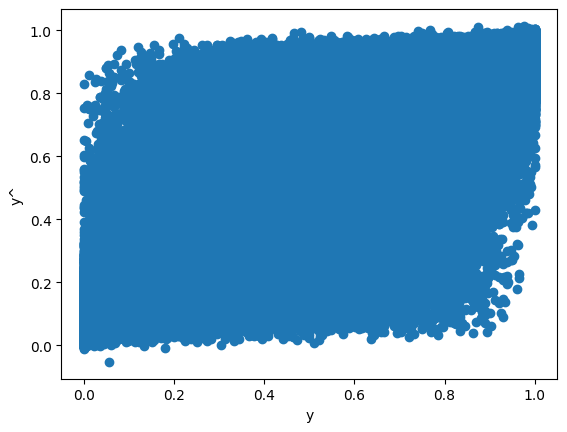


Testing time: 0.061 s
----- EVALUATION ON VAL SET ------
MSE: 0.011916114480362231
RMSE 0.10916095675818452
MAE: 0.07266395560860087
R^2:  0.8370697365133948



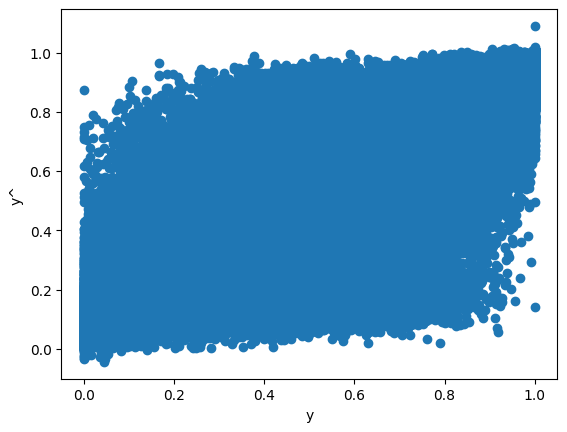

CPU times: user 18min 23s, sys: 4.83 s, total: 18min 27s
Wall time: 11min 36s


{'train': mse_t     0.010828
 rmse_t    0.104058
 mae_t     0.067459
 r2_t      0.852109
 dtype: object,
 'test': mse_t     0.008057
 rmse_t    0.089764
 mae_t     0.056663
 r2_t        0.8838
 mse_v     0.011916
 rmse_v    0.109161
 mae_v     0.072664
 r2_v       0.83707
 dtype: object}

In [122]:
%%time 

test_model_train_val_test(
    xgboosting, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

# {'train': mse_t      0.00792
#  rmse_t    0.088994
#  mae_t     0.058538
#  r2_t       0.89183
#  dtype: object,
#  'test': mse_t     0.009417
#  rmse_t    0.097042
#  mae_t     0.064621
#  r2_t      0.864193
#  mse_v     0.011833
#  rmse_v    0.108777
#  mae_v     0.073329
#  r2_v      0.838213
#  dtype: object}

In [96]:
Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2022], [2,3,4], True)

train
X (869116, 34) X_prepared: (869116, 23) y:  (869116,)
val
X (215285, 34) X_prepared: (215285, 23) y:  (215285,)
test
X (358887, 34) X_prepared: (358887, 23) y:  (358887,)


In [109]:
# define model 
# create an xgboost regression model
xgboosting = XGBRegressor(
    max_leaves=0,
    verbosity=0,
    n_jobs=10,
    random_state=config.seed,
    booster='gbtree',
    predictor='gpu_predictor'
)

param_grid = [
    {
        'max_depth':[5,6,7,8,9],
        'n_estimators':[100, 110, 120, 130, 140]
    }
]

grid_search = GridSearchCV(
    xgboosting, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [110]:
grid_search.fit(Xtr, ytr)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=  14.6s
[CV] END ......................max_depth=5, n_estimators=100; total time=  14.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=  14.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=  14.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=  13.9s
[CV] END ......................max_depth=5, n_estimators=110; total time=  15.5s
[CV] END ......................max_depth=5, n_estimators=110; total time=  15.4s
[CV] END ......................max_depth=5, n_estimators=110; total time=  15.4s
[CV] END ......................max_depth=5, n_estimators=110; total time=  15.6s
[CV] END ......................max_depth=5, n_estimators=110; total time=  15.0s
[CV] END ......................max_depth=5, n_estimators=120; total time=  16.4s
[CV] END ......................max_depth=5, n_e

[CV] END ......................max_depth=9, n_estimators=100; total time=  29.5s
[CV] END ......................max_depth=9, n_estimators=100; total time=  29.9s
[CV] END ......................max_depth=9, n_estimators=100; total time=  29.0s
[CV] END ......................max_depth=9, n_estimators=100; total time=  29.1s
[CV] END ......................max_depth=9, n_estimators=110; total time=  32.3s
[CV] END ......................max_depth=9, n_estimators=110; total time=  32.3s
[CV] END ......................max_depth=9, n_estimators=110; total time=  34.0s
[CV] END ......................max_depth=9, n_estimators=110; total time=  35.5s
[CV] END ......................max_depth=9, n_estimators=110; total time=  36.3s
[CV] END ......................max_depth=9, n_estimators=120; total time=  37.3s
[CV] END ......................max_depth=9, n_estimators=120; total time=  35.6s
[CV] END ......................max_depth=9, n_estimators=120; total time=  34.7s
[CV] END ...................

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=N...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=0,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=10, num_parallel_tree=None,
                                    predictor='gpu_predictor', random_state=42, ...),
             param_grid=[{'max_depth': [5, 6, 7, 8, 9],
                          'n_estimators': [100, 110, 120, 130, 140]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [111]:

print("the best parameters are:")
print(grid_search.best_params_)


the best parameters are:
{'max_depth': 9, 'n_estimators': 130}


In [112]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=0,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=130, n_jobs=10, num_parallel_tree=None,
             predictor='gpu_predictor', random_state=42, ...)

In [113]:
print("Best Score")
-grid_search.best_score_

Best Score


0.10628636521986128

In [114]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.10905590984890086 {'max_depth': 5, 'n_estimators': 100}
0.10889401577600658 {'max_depth': 5, 'n_estimators': 110}
0.10874300378960156 {'max_depth': 5, 'n_estimators': 120}
0.10862323310413764 {'max_depth': 5, 'n_estimators': 130}
0.10851325583324896 {'max_depth': 5, 'n_estimators': 140}
0.10789402735952272 {'max_depth': 6, 'n_estimators': 100}
0.10773501553697062 {'max_depth': 6, 'n_estimators': 110}
0.10763110263832336 {'max_depth': 6, 'n_estimators': 120}
0.10747170205347692 {'max_depth': 6, 'n_estimators': 130}
0.10735056944700563 {'max_depth': 6, 'n_estimators': 140}
0.10709569124421436 {'max_depth': 7, 'n_estimators': 100}
0.10699306324043423 {'max_depth': 7, 'n_estimators': 110}
0.10691650441197495 {'max_depth': 7, 'n_estimators': 120}
0.1068309434903221 {'max_depth': 7, 'n_estimators': 130}
0.10675241366827046 {'max_depth': 7, 'n_estimators': 140}
0.106580348446573 {'max_depth': 8, 'n_estimators': 100}
0.10649884211168052 {'max_depth': 8, 'n_estimators': 110}
0.106507471865721

In [115]:
results = grid_search.cv_results_

In [116]:
results

{'mean_fit_time': array([14.34758568, 15.34958038, 16.39651351, 17.56928749, 18.93390956,
        16.83530149, 18.40126281, 20.14697304, 21.86311183, 23.44644403,
        20.43609385, 22.34074116, 24.30365591, 26.30794744, 28.30363674,
        24.08189535, 26.42385006, 28.83219514, 34.23794804, 35.03405733,
        29.27172503, 34.03011103, 35.31039548, 37.72932954, 40.54396477]),
 'std_fit_time': array([0.29099258, 0.19712072, 0.12219173, 0.03644072, 0.06122334,
        0.08822986, 0.10663579, 0.1347156 , 0.16634124, 0.11230884,
        0.19767772, 0.14736952, 0.12232922, 0.17902492, 0.11563732,
        0.18913825, 0.06163579, 0.23918819, 1.98673538, 0.21849529,
        0.37798086, 1.63392286, 1.06395619, 0.63574237, 0.6076355 ]),
 'mean_score_time': array([0.0239543 , 0.02529087, 0.02502508, 0.02654834, 0.0278893 ,
        0.02569556, 0.02614703, 0.02701006, 0.02652798, 0.02855988,
        0.02622991, 0.05395794, 0.02920036, 0.03216743, 0.02954755,
        0.0284934 , 0.03030329, 0.0

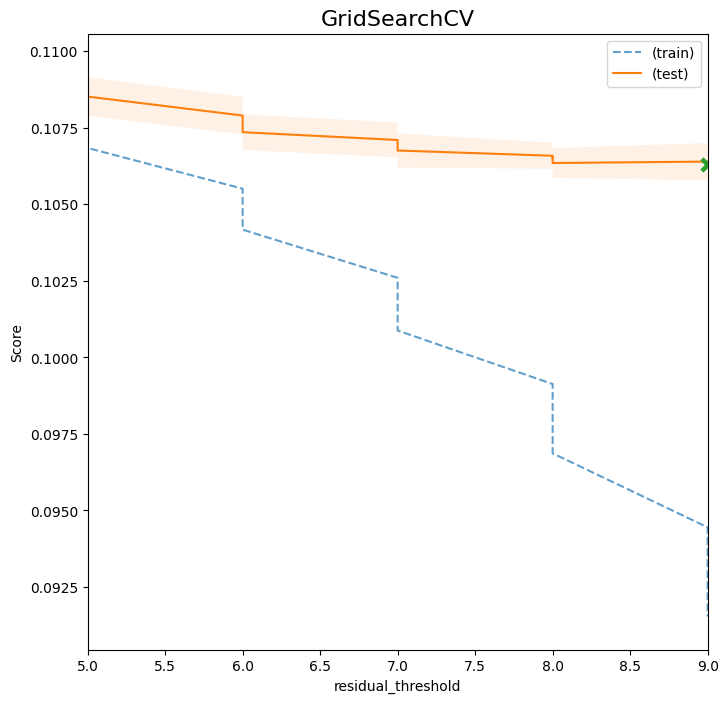

In [117]:
print_grid_result(results, 'param_max_depth')

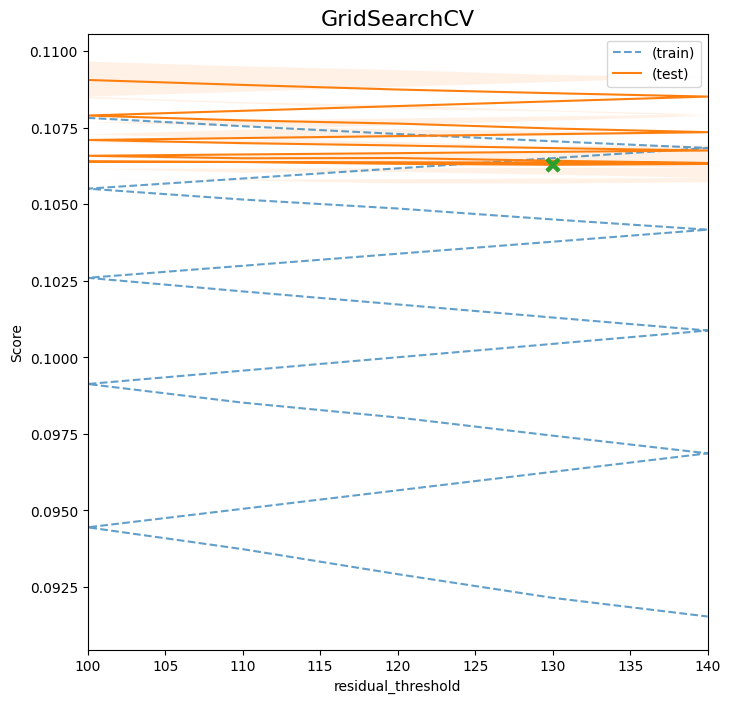

In [118]:
print_grid_result(results, 'param_n_estimators')

# Generate Sample

In [123]:
sample_data = pd.read_csv('dades/processed/kaggle_sample_data.csv')

In [124]:
sample_data

,index,station_id,month,day,hour,ctx4,ctx3,ctx2,ctx1,year,dayofweek,dayofyear,ctx1_ctx2_mean,ctx1_ctx2_std,ctx1_ctx2_ctx3_mean,ctx1_ctx2_ctx3_std,ctx1_ctx2_ctx3_ctx4_mean,ctx1_ctx2_ctx3_ctx4_std,lon,lat,festius,festius_sun,festius_sun_sat,weekend,VALOR_TN_X4,VALOR_TM_X4,VALOR_TX_X4,VALOR_PPT_X4,capacity
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66,0.811728,0.017459,0.801440,2.167830e-02,0.789352,0.029964,2.163126,41.387306,0,0,0,0,8.7,13.9,20.6,0.0,27
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82,0.567029,0.048678,0.556763,3.874158e-02,0.533514,0.056237,2.120494,41.398624,0,0,1,0,13.4,15.2,18.7,0.0,24
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90,0.606481,0.006547,0.640947,5.987442e-02,0.677469,0.087895,2.175660,41.396839,0,0,0,0,13.2,16.7,25.4,0.0,28
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82,0.777778,0.058926,0.788194,4.540520e-02,0.779514,0.040937,2.134603,41.405007,0,0,1,0,13.4,15.2,18.7,0.0,24
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63,0.820988,0.008730,0.814815,1.234568e-02,0.826389,0.025248,2.134469,41.402988,0,0,1,1,7.3,10.9,14.6,0.0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73,0.478261,0.000000,0.478261,6.798700e-17,0.478261,0.000000,2.192940,41.448152,0,0,0,0,13.5,17.0,22.2,0.0,28
54995,54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2,60,0.075617,0.002182,0.075103,1.781945e-03,0.081019,0.011920,2.177727,41.413866,0,0,0,0,4.5,8.2,11.4,0.0,27
54996,54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0,79,0.794935,0.024263,0.803922,2.316576e-02,0.798611,0.021693,2.138822,41.367557,0,0,0,0,12.0,14.4,17.2,0.0,51
54997,54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1,73,0.722222,0.353553,0.799383,2.834806e-01,0.793210,0.231790,2.168996,41.408211,0,0,0,0,13.5,17.0,22.2,0.0,27


## apply pipeline

In [125]:
X_sample_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train_prepared.shape)
print("x_test_prepared:",X_val_prepared.shape,"y_test: ",y_val_prepared.shape)
print("x_test_prepared:",X_test_prepared.shape,"y_test: ",y_test_prepared.shape)
print("x_test_prepared:",X_sample_prepared.shape)

x_train_prepared: (4108638, 23) y_train:  (4108638,)
x_test_prepared: (1016614, 23) y_test:  (1016614,)
x_test_prepared: (358887, 23) y_test:  (358887,)
x_test_prepared: (54999, 23)


## Prediction 

In [126]:
%%time 

model = xgboosting

CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 826 µs


In [127]:
name = f'{model.__class__}'.split('.')[-1]
name = name.translate( { ord(i): None for i in "'<>"})
number = 1

In [128]:
name

'XGBRegressor'

In [129]:
yhat = model.predict(X_sample_prepared)

In [130]:
yhat.shape

(54999,)

In [131]:
sample_data['percentage_docks_available'] = yhat

In [132]:
sample_data['percentage_docks_available'].to_csv(f'{name}{number}.csv', header=True, index_label='index')

In [133]:

aux = X_test[X_test.month.isin([3]) & X_test.station_id.isin(sample_data.station_id.unique())][['station_id', 'year', 'month','day','hour', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4']]


In [134]:
sample_data = sample_data.merge(aux,
                                on=['station_id','month','day','hour'],
                                how='left')

In [135]:
sample_data

,index,station_id,month,day,hour,ctx4_x,ctx3_x,ctx2_x,ctx1_x,year_x,dayofweek,dayofyear,ctx1_ctx2_mean,ctx1_ctx2_std,ctx1_ctx2_ctx3_mean,ctx1_ctx2_ctx3_std,ctx1_ctx2_ctx3_ctx4_mean,ctx1_ctx2_ctx3_ctx4_std,lon,lat,festius,festius_sun,festius_sun_sat,weekend,VALOR_TN_X4,VALOR_TM_X4,VALOR_TX_X4,VALOR_PPT_X4,capacity,percentage_docks_available,year_y,ctx0,ctx1_y,ctx2_y,ctx3_y,ctx4_y
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66,0.811728,0.017459,0.801440,2.167830e-02,0.789352,0.029964,2.163126,41.387306,0,0,0,0,8.7,13.9,20.6,0.0,27,0.745036,2023.0,0.693603,0.820513,0.802469,0.777778,0.753086
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82,0.567029,0.048678,0.556763,3.874158e-02,0.533514,0.056237,2.120494,41.398624,0,0,1,0,13.4,15.2,18.7,0.0,24,0.656924,2023.0,0.673913,0.619565,0.539130,0.530435,0.456522
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90,0.606481,0.006547,0.640947,5.987442e-02,0.677469,0.087895,2.175660,41.396839,0,0,0,0,13.2,16.7,25.4,0.0,28,0.600141,2023.0,0.562963,0.601852,0.600823,0.709877,0.787037
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82,0.777778,0.058926,0.788194,4.540520e-02,0.779514,0.040937,2.134603,41.405007,0,0,1,0,13.4,15.2,18.7,0.0,24,0.742415,2023.0,0.883333,0.722222,0.802083,0.812500,0.760417
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63,0.820988,0.008730,0.814815,1.234568e-02,0.826389,0.025248,2.134469,41.402988,0,0,1,1,7.3,10.9,14.6,0.0,27,0.816061,2023.0,0.759259,0.827160,0.814815,0.802469,0.861111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73,0.478261,0.000000,0.478261,6.798700e-17,0.478261,0.000000,2.192940,41.448152,0,0,0,0,13.5,17.0,22.2,0.0,28,0.479521,2023.0,0.478261,0.478261,0.478261,0.478261,0.478261
54995,54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2,60,0.075617,0.002182,0.075103,1.781945e-03,0.081019,0.011920,2.177727,41.413866,0,0,0,0,4.5,8.2,11.4,0.0,27,0.122901,2023.0,0.067901,0.077160,0.074074,0.074074,0.098765
54996,54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0,79,0.794935,0.024263,0.803922,2.316576e-02,0.798611,0.021693,2.138822,41.367557,0,0,0,0,12.0,14.4,17.2,0.0,51,0.759228,2023.0,0.820728,0.780392,0.810458,0.852941,0.777778
54997,54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1,73,0.722222,0.353553,0.799383,2.834806e-01,0.793210,0.231790,2.168996,41.408211,0,0,0,0,13.5,17.0,22.2,0.0,27,0.544511,2023.0,0.722222,0.451852,0.990741,0.958333,0.703704


In [136]:

sample_data[['station_id', 'month', 'day', 'hour', 'percentage_docks_available', 'ctx0', 'ctx1_x', 'ctx1_y', 'ctx4_x', 'ctx4_y', 'ctx3_x', 'ctx3_y', 'ctx2_x', 'ctx2_y']]



,station_id,month,day,hour,percentage_docks_available,ctx0,ctx1_x,ctx1_y,ctx4_x,ctx4_y,ctx3_x,ctx3_y,ctx2_x,ctx2_y
0,394,3,7,8,0.745036,0.693603,0.824074,0.820513,0.753086,0.753086,0.780864,0.777778,0.799383,0.802469
1,337,3,23,12,0.656924,0.673913,0.601449,0.619565,0.463768,0.456522,0.536232,0.530435,0.532609,0.539130
2,368,3,31,1,0.600141,0.562963,0.601852,0.601852,0.787037,0.787037,0.709877,0.709877,0.611111,0.600823
3,327,3,23,15,0.742415,0.883333,0.736111,0.722222,0.753472,0.760417,0.809028,0.812500,0.819444,0.802083
4,328,3,4,20,0.816061,0.759259,0.827160,0.827160,0.861111,0.861111,0.802469,0.802469,0.814815,0.814815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.479521,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261
54995,280,3,1,5,0.122901,0.067901,0.077160,0.077160,0.098765,0.098765,0.074074,0.074074,0.074074,0.074074
54996,180,3,20,16,0.759228,0.820728,0.777778,0.780392,0.782680,0.777778,0.821895,0.852941,0.812092,0.810458
54997,277,3,14,11,0.544511,0.722222,0.472222,0.451852,0.774691,0.703704,0.953704,0.958333,0.972222,0.990741


<Axes: >

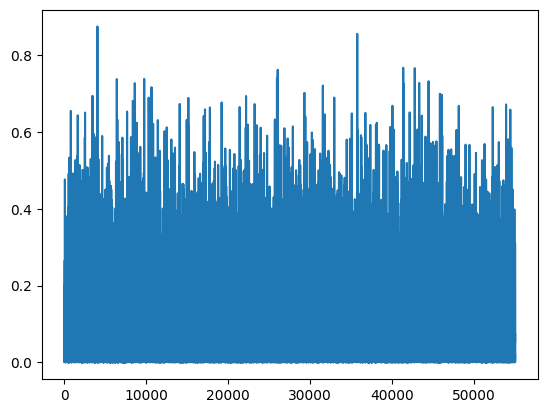

[CV] END .................................................... total time= 9.1min
[CV] END .................................................... total time= 9.1min
[CV] END .................................................... total time= 9.1min
[CV] END .................................................... total time= 9.1min
[CV] END .................................................... total time= 9.1min


In [137]:
np.abs(sample_data['percentage_docks_available'] - sample_data['ctx0']).plot()